<a href="https://colab.research.google.com/github/suzgunmirac/Battleship/blob/master/Ben%26Mirac_FTML_Basic_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries and relevant dependencies

In [0]:
import torch
import torch.distributions as ds
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [0]:
# Matplotlib plt default settings
plt.style.use('default')

## Data Generation

In [0]:
# Global params
task_n = 20
points_per_task = 100
task_batch_size = 10
num_meta_steps = 20
num_task_steps = 10

data_split = 0.9
meta_data_split = 0.5

In [0]:
# Construct task space (generate permutations of given amplitudes and phases for sinusoid function)
def generate_task_space(task_num = 10):
    task_space = []
    for task in range (task_num):
        # amplitude
        amplitude = ds.uniform.Uniform(0.1, 5).sample()
        # phase
        phase = ds.uniform.Uniform(0., np.pi).sample()
        # append a new task
        task_space.append([amplitude, phase])
    return task_space

In [0]:
# Generate x values on interval [-5, 5]
def sample_input(size = 100):    
    input_unif = ds.uniform.Uniform(-5.0, 5.0)
    x = input_unif.sample(torch.Size([size]))
    return x

In [0]:
# Plot some of the functions 
def plot_sample_functions():
    # generate n number of tasks (task_n = 10)
    task_space = generate_task_space(task_n)
    
    for function in range(task_n):
        # choose one of the functions uniformly at random (redundant)
        f_params_index = np.random.choice(np.arange(0, len(task_space)))
        f_params = task_space[f_params_index]
        
        points = sample_input (points_per_task).numpy()
        # Sorting (just to make sure that we are plotting from left to right)
        points.sort()
        
        plt.plot(points, np.array([f_params[0] * np.sin(point + f_params[1]) for point in points]))
        plt.title("Amplitude = {}, Phase = {}".format(f_params[0], f_params[1]))
        plt.hlines(y=0, xmin=-5.0, xmax=5.0)
        plt.ylim(-5.0, 5.0)
        plt.show()

### Model Architecture 

In [0]:
# Modeled on NN for simple regression task from Finn et al., 2017
class FFNN(nn.Module):
    def __init__(self):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(1, 40)
        self.fc2 = nn.Linear(40, 40)
        self.fc3 = nn.Linear(40, 1)
        self.relu = nn.ReLU() 
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

In [0]:
# Generate sequence of tasks for use in online meta learning context

# num_rounds = t and num_task_points = N ("points_per_task" in our case)
def generate_task_sequence(num_rounds):
    
    # Generate tasks
    task_space = generate_task_space(task_n)
    
    assert num_rounds <= len(task_space)
    # Stores parameters corresponding to each task (in correct ordering based on keys)
    
    task_sequence = {}
    
    # Stores data corresponding to each task (in correct ordering based on keys) [BUFFER]
    sequence_data = {}
    
    task_counter = 0
    
    # Selects tasks without replacement 
    np.random.shuffle(task_space)
    
    while task_counter < num_rounds:
        task_counter += 1
        
        # sample a task (the world gives us a task)
        f_params = task_space.pop()
        
        # Generate data for this task 
        task_inputs = sample_input (points_per_task).numpy()
        task_inputs.sort()
        task_inputs = torch.tensor (task_inputs)
        
        # Generate the corresponding target values (with some Gaussian noise)
        task_outputs = torch.zeros (points_per_task)
        
        for i in range(points_per_task):
            noise = torch.normal(torch.tensor(0.), torch.tensor(.0001))
            task_outputs[i] = f_params[0] * np.sin(task_inputs[i] + f_params[1]) + noise
            # task_outputs[i] = torch.tensor (1.)

        task_sequence[task_counter] = f_params
        
        sequence_data[task_counter] = {'X': task_inputs, 'Y': task_outputs}
    
    # Task sequence stores parameters used to generate function, sequence_data stores corresponding data
    return task_sequence, sequence_data

In [0]:
# Generate task sequence, sequence data 
task_sequence, sequence_data = generate_task_sequence(10)

## Training 

### Naive Model + Training Procedure

In [0]:
# Dumb/Naive model 

def train_naive_model(model, criterion, optim, num_epochs, batch_size, data, test_data):
    model.train ()
    
    train_X, train_Y = data
    
    test_X, test_Y = test_data
    
    
    losses = []
    
    test_losses = []
    
    # Run optimization
    for epoch in range(num_epochs):
        batch_index = 0
        loss = 0.
        while batch_index < len(train_X):
            optim.zero_grad()
            
            batch_X = train_X[batch_index : batch_index + batch_size].view(-1, 1)
            batch_Y = train_Y[batch_index : batch_index + batch_size].view(-1, 1)
            
            predictions = model (batch_X)
            
            # double check
            loss = criterion (predictions, batch_Y)
            
            loss.backward()
            optim.step()
            
            losses.append(loss.item())
            batch_index += batch_size
            
        test_loss = loss_eval (model, (test_X, test_Y), epoch)
        
        test_losses.append(test_loss.item())
            
    plt.plot(np.arange(1, len(losses) + 1), np.array(losses))
    plt.title("Training Loss | Naive Model")
    plt.ylabel ('Mean Squared Error')
    plt.xlabel ('Iteration')
    plt.savefig ('naive_model_loss', dpi=256)
    plt.show()
    
    print (test_losses)
    plt.plot(np.arange(1, num_epochs + 1), np.array(test_losses), '-o')
    plt.title("Test Loss | Naive Model")
    plt.ylabel ('Mean Squared Error')
    plt.xlabel ('Epoch')
    plt.savefig ('naive_model_test_loss', dpi=256)
    plt.show()
    
    
    # return model

In [0]:
# Model parameters

learning_rate = 0.001
num_epochs = 25
batch_size = 16

model = FFNN()
criterion = nn.MSELoss() 
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [0]:
def naive_train_test_split (data):
    # Concatenate data from all tasks 
    X = torch.tensor([])
    Y = torch.tensor([])

    for task_key in range(1, len(data) + 1):
        X = torch.cat((X, data[task_key]['X']))
        Y = torch.cat((Y, data[task_key]['Y']))

    X = X.flatten()
    Y = Y.flatten()
    
    # Shuffle data to ensure data from tasks distributed evenly 
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    reordered_X = []
    reordered_Y = []

    for index in indices:
        reordered_X.append(X[index])
        reordered_Y.append(Y[index])     

    train_X = torch.tensor(reordered_X[:int(data_split * len(X))])
    train_Y = torch.tensor(reordered_Y[:int(data_split * len(Y))])

    test_X = torch.tensor(reordered_X[int(data_split * len(X)):])
    test_Y = torch.tensor(reordered_Y[int(data_split * len(Y)):])
    
    return [(train_X, train_Y), (test_X, test_Y)]

In [0]:
# Training and test sets
(train_input, train_output), (test_input, test_output) = naive_train_test_split (sequence_data)

Loss for round 1: 24.8556079865
Loss for round 2: 24.7436904907
Loss for round 3: 24.6538391113
Loss for round 4: 24.5649662018
Loss for round 5: 24.4079551697
Loss for round 6: 24.3061199188
Loss for round 7: 24.1796531677
Loss for round 8: 24.0304775238
Loss for round 9: 23.890127182
Loss for round 10: 23.7183933258
Loss for round 11: 23.5986270905
Loss for round 12: 23.4128513336
Loss for round 13: 23.2990665436
Loss for round 14: 23.2337722778
Loss for round 15: 23.1602268219
Loss for round 16: 23.0974845886
Loss for round 17: 23.0463409424
Loss for round 18: 22.9864082336
Loss for round 19: 22.9438877106
Loss for round 20: 22.8939685822
Loss for round 21: 22.8685646057
Loss for round 22: 22.8340187073
Loss for round 23: 22.8089637756
Loss for round 24: 22.7868480682
Loss for round 25: 22.7723999023


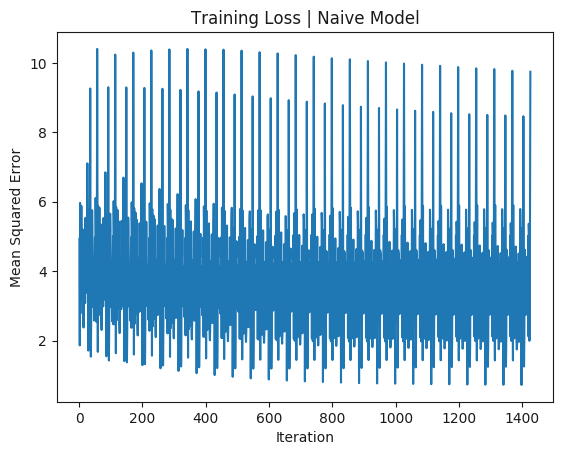

[24.855607986450195, 24.743690490722656, 24.653839111328125, 24.564966201782227, 24.407955169677734, 24.306119918823242, 24.17965316772461, 24.03047752380371, 23.890127182006836, 23.718393325805664, 23.5986270904541, 23.412851333618164, 23.2990665435791, 23.23377227783203, 23.160226821899414, 23.097484588623047, 23.046340942382812, 22.986408233642578, 22.94388771057129, 22.89396858215332, 22.86856460571289, 22.83401870727539, 22.808963775634766, 22.786848068237305, 22.77239990234375]


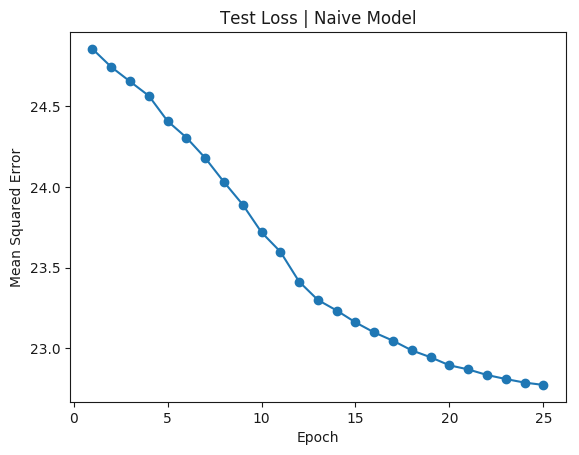

In [18]:
naive_model = train_naive_model(model, criterion, optim, num_epochs, batch_size , (train_input, train_output), (test_input, test_output))

### Follow the Meta-Leader

In [0]:
# online meta-learning model params
meta_learning_rate = 0.001
task_learning_rate = 0.01

num_epochs = 10
batch_size = 16

meta_model = FFNN()
criterion = nn.MSELoss() 
meta_optim = torch.optim.Adam(meta_model.parameters(), lr = meta_learning_rate)

In [0]:
def visualize_results (m_model, data, task, label_num = 1):  
    
    viz_steps = [0, 9]
    
    data_X, data_Y = data
    
    data_X = data_X.tolist()
    
    data_X.sort()
    
    data_Y = []
    
    for x in data_X:
        data_Y.append(task[0] * np.sin(x + task[1]))
      
    data_X = torch.tensor(data_X)
    data_Y = torch.tensor(data_Y)

    task_model_predictions = task_update(m_model, (data_X, data_Y), visualize=True, viz_steps=viz_steps)
    
    # Turn on the eval mode
    m_model.eval()
    
    meta_model_predictions = m_model (data_X.view(-1, 1)).detach()
        
    plt.figure()
    
    x_inputs = data_X.numpy()
    
#     plt.plot (x_inputs, data_Y.numpy(), '-o', 'r', label='Target pt')
    plt.plot (np.linspace(-5, 5, 301), np.array([task[0] * np.sin(x + task[1]) for x in np.linspace(-5, 5, 301)]), '-', color='red', label = 'Ground truth')
    plt.plot (x_inputs, meta_model_predictions.numpy(), '--', color='green', label = 'Pre-update')
    
    for prediction_index in range(len(task_model_predictions)):
        num = viz_steps[prediction_index] + 1
        lbl = 'After '
        if num == 1:
            lbl += '{} grad update'.format(num)
        else:
            lbl += '{} grad updates'.format(num)

        plt.plot(x_inputs, task_model_predictions[prediction_index].numpy(), '.-', label = lbl)
    
    # plt.title ('Model-Agnostic Meta-Learning for Simple Regression Task')
    # plt.legend(loc='upper right')
    plt.ylim(-7, 7)
    plt.savefig('ftml_result_{}'.format(label_num), dpi=256)
    plt.show()
    

In [0]:
def loss_eval (model, data, round_t):
    with torch.no_grad():
        
        # Turn on the eval mode
        model.eval()
        
        data_X, data_Y = data
        
        # Evaluate loss
        loss = 0
        
        batch_index = 0
        while batch_index < len(data_X):
                        
            batch_X = data_X[batch_index : batch_index + batch_size].view(-1, 1)
            batch_Y = data_Y[batch_index : batch_index + batch_size].view(-1, 1)

            predictions = model (batch_X)
            
            loss += criterion (predictions, batch_Y)
            
            batch_index += batch_size
            
        # loss /= batch_index
        
        print("Loss for round {}: {}".format(round_t + 1, loss))
        
        return loss

In [0]:
def meta_update(model, optim, task_buffer, sequence_data):
    # Turn on the train mode
    model.train ()
    
    for step in range(num_meta_steps):
        # Sample task from history of tasks 
        task_cat = ds.categorical.Categorical(probs=torch.div(torch.ones(len(task_buffer)), len(task_buffer)))
        k = task_cat.sample()
        task_X, task_Y = sequence_data[task_buffer[k]]
        
        # Sample minibatches from training and validation        
        data_indices = np.arange(len(task_X))
        np.random.shuffle(data_indices)
        
        reordered_X = []
        reordered_Y = []
        
        for i in data_indices:
            reordered_X.append(task_X[i])
            reordered_Y.append(task_Y[i])
            
        train_X = torch.tensor(reordered_X[:int(meta_data_split * len(reordered_X))])
        train_Y = torch.tensor(reordered_Y[:int(meta_data_split * len(reordered_X))])
        val_X = torch.tensor(reordered_X[int(meta_data_split * len(reordered_X)):])
        val_Y = torch.tensor(reordered_Y[int(meta_data_split * len(reordered_X)):])
        
        # calculating U_k (w)
        task_model = task_update(model, (train_X, train_Y))

        # Update meta-parameters   
        optim.zero_grad()
        
        # Compute averaged loss
        loss = 0
        
        batch_index = 0
        while batch_index < len(train_X):
                        
            batch_X = val_X[batch_index : batch_index + batch_size].view(-1, 1)
            batch_Y = val_Y[batch_index : batch_index + batch_size].view(-1, 1)
            
            predictions = task_model (batch_X)
            
            loss += criterion (predictions, batch_Y)
            
            batch_index += batch_size
            
        # loss /= batch_index
        
        loss.backward()
        
        optim.step()

    return model

In [0]:
def task_update(model, data, visualize=False, viz_steps = [0, 19]):
    ## Initialization
    # Create a copy of the meta-model
    new_model = type(model)()
    new_model.load_state_dict (model.state_dict())
    
    new_optim = torch.optim.Adam(new_model.parameters(), lr = task_learning_rate)
    
    data_X, data_Y = data
    
    visualization_predictions = []
        
    # Turn on the train mode
    new_model.train()
    
    for step in range (num_task_steps):
        batch_index = 0
        while batch_index < len(data_X):
            new_optim.zero_grad()
            
            batch_X = data_X[batch_index : batch_index + batch_size].view(-1, 1)
            batch_Y = data_Y[batch_index : batch_index + batch_size].view(-1, 1)
            
            predictions = new_model (batch_X)

            # double check
            loss = criterion (predictions, batch_Y)
            
            loss.backward()
            new_optim.step()
            
            # losses.append(loss.item())
            batch_index += batch_size
        
        if visualize and step in viz_steps:
            visualization_predictions.append(new_model(data_X.view(-1, 1)).detach())
        
    if visualize:
        return visualization_predictions
    else:
        return new_model

In [0]:
def online_meta_learning (model, data):
    # Initialize the meta-model params
    # model = model
    
    # Turn on the train mode
    model.train()
    
    # Init task buffer 
    task_buffer = []
    sequence_data = {}
    test_losses = []
    
    meta_losses = []
    tilde_losses = []
    
    # The world decides on the sequence of task
    task_indices = np.arange(1, len(task_sequence) + 1)
    np.random.shuffle(task_indices)
    
    # In each round, we present samples from one particular task
    for round_t in range (len(data)):

        # Store observed task in task buffer
        task_buffer.append (task_indices[round_t])
        
        # Shuffle sequence data (to prevent unnatural ordering)
        task_data = data[task_indices[round_t]]
        data_indices = np.arange(points_per_task)
        np.random.shuffle(data_indices)
        
        reordered_X = []
        reordered_Y = []
        
        for i in data_indices:
            reordered_X.append(task_data['X'][i])
            reordered_Y.append(task_data['Y'][i])
            
        # Create task test-train split
        train_X = torch.tensor(reordered_X[:int(data_split * points_per_task)])
        train_Y = torch.tensor(reordered_Y[:int(data_split * points_per_task)])
        test_X = torch.tensor(reordered_X[int(data_split * points_per_task):])
        test_Y = torch.tensor(reordered_Y[int(data_split * points_per_task):])

        # Maintain task online data buffer 
        task_X = torch.tensor([])
        task_Y = torch.tensor([])
        
        data_counter = 0
        
        if round_t > 0:
            veteran_model = type(model)()
            veteran_model.load_state_dict (model.state_dict())

            # visualize_results (veteran_model, (train_X, train_Y), task_sequence[task_buffer[-1]], label_num = round_t)
                
        while len(task_X) < (data_split * points_per_task):

            # Append batch_size data points to online data buffer 
            task_X = torch.cat((task_X, train_X[data_counter : data_counter + task_batch_size]))
            task_Y = torch.cat((task_Y, train_Y[data_counter : data_counter + task_batch_size]))
            
            data_counter += task_batch_size
            
            # Store observed data 
            sequence_data[task_indices[round_t]] = (task_X, task_Y)
            
            # Perform meta-model update
            model = meta_update(model, meta_optim, task_buffer, sequence_data)
            
            
            # Perform task update
            model_tilde = task_update(model, (task_X, task_Y))
            
        # Final performance on the test set 
        meta_loss = loss_eval (model, (test_X, test_Y), round_t)
        test_loss = loss_eval (model_tilde, (test_X, test_Y), round_t)
        
        meta_losses.append (meta_loss)
        test_losses.append(test_loss)
    
    plt.plot(np.arange(1, len(data) + 1), np.array(meta_losses), '-ob', label= 'Meta-model')
    plt.plot(np.arange(1, len(data) + 1), np.array(test_losses), '-*r', label='Task-specific model')
    plt.title("Test Loss on Online Meta-Learning Task")
    plt.ylabel ('Mean Squared Error')
    plt.xlabel ('Round')
    plt.legend(loc='upper right')
    plt.savefig ('maml_losses', dpi=256)
    
    plt.show()

In [0]:
online_meta_learning(model, sequence_data)

Loss for round 1: 1.37974989414
Loss for round 1: 0.0707615688443
Loss for round 2: 1.35018360615
Loss for round 2: 0.0983143001795
Loss for round 3: 1.19173789024
Loss for round 3: 0.449582338333
Loss for round 4: 5.73060464859
Loss for round 4: 0.148814409971
Loss for round 5: 1.69762504101
Loss for round 5: 0.0152542674914
Loss for round 6: 5.2650976181
Loss for round 6: 0.43321326375
Loss for round 7: 1.55217838287
Loss for round 7: 0.69498693943
Loss for round 8: 0.106720343232
Loss for round 8: 0.00517320260406


## Bayesian Online Meta-Learning

In [0]:
# online meta-learning model params
bayes_meta_learning_rate = 0.001
bayes_task_learning_rate = 0.01

num_epochs = 10
batch_size = 16
observation_noise_variance = 0.01
prior_mean, prior_variance = 0., 1.

# Chaser is n in BMAML
chaser_steps = 1
# Leader is n + s in BMAML
leader_steps = 1

kernel_sigma_squared = 1.

model_number_M = 5

ensemble_meta_models = [FFNN() for _ in range (model_number_M)]
# bayes_meta_optims = [torch.optim.Adam(ensemble_meta_models[i].parameters(), lr=meta_learning_rate) for i in range(model_number_M)]
criterion = nn.MSELoss() 

In [0]:
# This is fine
# Randomly establish 1-1 mapping between models
pairwise_mapping = {}
model_indices = np.arange(model_number_M)
np.random.shuffle(model_indices)
for i in range(model_number_M):
  pairwise_mapping[i] = model_indices[i]

In [0]:
def ensemble_loss_eval (models, data, round_t):

    with torch.no_grad():
        
        # Turn on the eval mode
        for i in range(model_number_M):
          models[i].eval()
        
        data_X, data_Y = data
        
        # Evaluate loss
        loss = 0
        
        batch_index = 0
        while batch_index < len(data_X):
                        
            batch_X = data_X[batch_index : batch_index + batch_size].view(-1, 1)
            batch_Y = data_Y[batch_index : batch_index + batch_size].view(-1, 1)

            
            for model in models:
              predictions = model (batch_X)
              loss += criterion (predictions, batch_Y)
            
            batch_index += batch_size
            
        loss /= (1. / (1. * model_number_M))
        
        print("Loss for round {}: {}".format(round_t + 1, loss))
        
        return loss

In [0]:
# This is fine
def compute_chaser_loss (theta_n, theta_n_s):
  
    flattened_theta_n = []
    flattened_theta_n_s = []
    
    for i in range(model_number_M):
      flattened_n_model = torch.tensor([])
      flattened_n_s_model = torch.tensor([])
      for name, param in theta_n[i].named_parameters():
        if param.requires_grad:
          flattened_n_model = torch.cat((flattened_n_model, param.flatten()))
      for name, param in theta_n_s[i].named_parameters():
        if param.requires_grad:
          flattened_n_s_model = torch.cat((flattened_n_s_model, param.flatten()))
      flattened_theta_n.append(flattened_n_model)
      flattened_theta_n_s.append(flattened_n_s_model)
    
    loss = 0
    for i in range(model_number_M):
      diff = flattened_theta_n[i] - flattened_theta_n_s[pairwise_mapping[i]]
      # squared euclidean distance
      loss += torch.dot(diff, diff)
      
    return loss

In [0]:
def bayesian_meta_update(models, task_buffer, sequence_data):
  
  # This is theta_0
  original_meta_models = [type(model)() for model in models]  
  for i in range(model_number_M):
    original_meta_models[i].load_state_dict (models[i].state_dict())
  
  # Turn on the train mode
  for i in range (model_number_M):
    # These are theta_0_prime
    models[i].train()    

  for step in range(num_meta_steps):
      # Sample task from history of tasks 
      task_cat = ds.categorical.Categorical(probs=torch.div(torch.ones(len(task_buffer)), len(task_buffer)))
      k = task_cat.sample()
      task_X, task_Y = sequence_data[task_buffer[k]]

      # Sample minibatches from training and validation        
      data_indices = np.arange(len(task_X))
      np.random.shuffle(data_indices)

      reordered_X = []
      reordered_Y = []

      for i in data_indices:
          reordered_X.append(task_X[i])
          reordered_Y.append(task_Y[i])

      train_X = torch.tensor(reordered_X[:int(meta_data_split * len(reordered_X))])
      train_Y = torch.tensor(reordered_Y[:int(meta_data_split * len(reordered_X))])
      
      # At some point in backpropagating, we are going to use the partial d(theta_n) / d(theta_0_prime)
      theta_n = bayesian_task_update (models, (train_X, train_Y), chaser_steps)
      
      theta_n_prime = [type(theta_n_model) for theta_n_model in theta_n]
      for i in range(model_number_M):
        theta_n_prime[i].load_state_dict (theta_n[i].state_dict())   
      
      # Note we are using the full dataset here (both train and val)
      theta_n_s = bayesian_task_update (theta_n_prime, (torch.tensor(reordered_X), torch.tensor(reordered_Y)), leader_steps)

      loss = compute_chaser_loss (theta_n_prime, theta_n_s)

      loss.backward()
      
      gradient = {}
      for i in range(model_number_M):
        for name, param in models[i].named_parameters():
          gradient[name] = param.grad

      for i in range (model_number_M):      
        for name, param in original_meta_models[i].named_parameters():
          if param.requires_grad:
            # Use param.grad for models to update param.data of meta_models
            param.data -= bayes_meta_learning_rate * gradient[name]

  return models

In [0]:
def compute_kernel (model_l, model_j):
    model_l_parameter_values = torch.tensor([], requires_grad=True)
    model_j_parameter_values = torch.tensor([], requires_grad=True)
    
    # Flatten the weights of model l
    for name, param in model_l.named_parameters():
      if param.requires_grad:
        parameter_values = torch.cat((model_l_parameter_values, param.flatten()))
    
    # Flatten the weights of model j
    for name, param in model_j.named_parameters():
      if param.requires_grad:
        parameter_values = torch.cat((model_j_parameter_values, param.flatten()))
        
    diff = model_l_parameter_values - model_j_parameter_values
    
    # squared euclidean distance
    sqd = torch.dot(diff, diff) 
    
    # Ben approves! (yay)
    distance = torch.exp(-(sqd / (2. * kernel_sigma_squared)))
    
    return distance

In [0]:
def compute_gradient (model, ensemble, data):
    
  data_X, data_Y = data
  
  variances = observation_noise_variance * torch.ones(len(data_X))
  
  gradient = {}
#   for name, param in model.named_parameters():
#     if param.requires_grad:
#       gradient[name] = torch.zeros(param.shape)
        
  for j in range (model_number_M):
    for l in range (model_number_M):
      
      ensemble[l].eval()
      means = model(data_X.view(-1, 1))
      
      likelihood_mvn = ds.multivariate_normal.MultivariateNormal(means, torch.diag(variances))
      log_likelihood = likelihood_mvn.log_prob(data_Y).sum()
      
      parameter_values = torch.tensor([])
      
      for name, param in model.named_parameters():
        if param.requires_grad:
          parameter_values = torch.cat((parameter_values, param.flatten()))
      
      # Possible error here from backpropping through PDF
      prior_mvn = ds.multivariate_normal.MultivariateNormal(torch.zeros(parameter_values.shape), torch.eye(parameter_values.shape[0]))
      log_prior = prior_mvn.log_prob(parameter_values).sum()
      
      kernel_value = compute_kernel (ensemble[l], ensemble[j]) 
      kernel_value.backward()
      
      for name, param in ensemble[l].named_parameters():
        if param.requires_grad:
          gradient[name] = param.grad
          # Think about whether we want to zero out gradient 
          param.grad.zero_()
          
      prob_term = log_likelihood + log_prior
      
      prob_term.backward()
      
      for name, param in ensemble[l].named_parameters():
        if param.requires_grad:
          gradient[name] += (kernel_value * param.grad)
          # Think about whether we want to zero out gradient
          param.grad.zero_()
      

          
  for key, value in gradient.items():
    gradient[key] = (1. / (1. * model_number_M)) * value

  return gradient 

In [0]:
def bayesian_task_update (models, data, num_task_steps, visualize=False, viz_steps = [0, 19]):
   
    ## Initialization
    new_models = [type(model)() for model in models]
    for i in range(model_number_M):
        new_models[i].load_state_dict (models[i].state_dict())
        
    # Turn on the train mode
    for i in range (model_number_M):
        new_models[i].train()
        
    visualization_predictions = []
    
    for step in range (num_task_steps):
        # New_model == particle
        for i in range(model_number_M):
          
          # Get gradient
          gradient = compute_gradient (new_models[i], new_models, data)
          
          # Perform gradient update
          for name, param in models[l].named_parameters():
            if param.requires_grad:
              param.data += bayes_task_learning_rate * gradient[name]
            
    return new_models 

In [0]:
def bayesian_online_meta_learning (models, data):
    # Initialize the meta-model params
    # model = model
    
    # Turn on the train mode
    for i in range (model_number_M):
        models[i].train()
    
    # Init task buffer 
    task_buffer = []
    sequence_data = {}
    test_losses = []
    
    # The world decides on the sequence of task
    task_indices = np.arange(1, len(task_sequence) + 1)
    np.random.shuffle(task_indices)
    
    # In each round, we present samples from one particular task
    for round_t in range (len(data)):

        # Store observed task in task buffer
        task_buffer.append (task_indices[round_t])
        
        # Shuffle sequence data (to prevent unnatural ordering)
        task_data = data[task_indices[round_t]]
        data_indices = np.arange(points_per_task)
        np.random.shuffle(data_indices)
        
        reordered_X = []
        reordered_Y = []
        
        for i in data_indices:
            reordered_X.append(task_data['X'][i])
            reordered_Y.append(task_data['Y'][i])
            
        # Create task test-train split
        train_X = torch.tensor(reordered_X[:int(data_split * points_per_task)])
        train_Y = torch.tensor(reordered_Y[:int(data_split * points_per_task)])
        test_X = torch.tensor(reordered_X[int(data_split * points_per_task):])
        test_Y = torch.tensor(reordered_Y[int(data_split * points_per_task):])

        # Maintain task online data buffer 
        task_X = torch.tensor([])
        task_Y = torch.tensor([])
        
        data_counter = 0
        
        if round_t > 0:
            veteran_model = type(model)()
            veteran_model.load_state_dict (model.state_dict())

            visualize_results (veteran_model, (train_X, train_Y), task_sequence[task_buffer[-1]])
                
        while len(task_X) < (data_split * points_per_task):

            # Append batch_size data points to online data buffer 
            task_X = torch.cat((task_X, train_X[data_counter : data_counter + task_batch_size]))
            task_Y = torch.cat((task_Y, train_Y[data_counter : data_counter + task_batch_size]))
            
            data_counter += task_batch_size
            
            # Store observed data 
            sequence_data[task_indices[round_t]] = (task_X, task_Y)
            
            # Perform meta-model update
            models = bayesian_meta_update (models, task_buffer, sequence_data)
            
            # Perform task update
            tilde_models = bayesian_task_update (models, (task_X, task_Y), chaser_steps)
        
        # ****** [TO-DO]  ******
        # Final performance on the test set
        test_loss = ensemble_loss_eval (tilde_models, (test_X, test_Y), round_t)
        
        test_losses.append(test_loss)
    
    plt.plot(np.arange(1, len(data) + 1), np.array(test_losses))
    plt.title("Test Loss on Bayesian Online Meta-Learning Task")
    plt.show()

In [0]:
bayesian_online_meta_learning (ensemble_meta_models, sequence_data)

AttributeError: ignored

## TO-DO LIST:



*   Relax our assumption about the frequency of tasks (i.e., we are currently assuming that the tasks are unique.)
*   Check that we are updating the correct set of parameters
